## We choose a window of 10 time steps
## We want to learn 8 steps and predict 2 steps.
## Each step = 1 second

In [17]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence, split_sequence_long
import math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Exploration

In [18]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [19]:
# show head
print(data.shape)
data.head()

(4597200, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [8]:
data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545


### Windowing
We choose a window of 60 time steps
We want to learn 48 steps and predict 12 steps.

In [9]:
window_size = 10
grouped_data = windowing_array(data, window_size)

In [10]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

459720
10
8


### Slice and Split sequence 

In [11]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [12]:
x_train_init.shape, x_test_init.shape

((367776, 10, 8), (91944, 10, 8))

In [13]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [14]:
x_train.shape, y_train.shape

((367776, 8, 8), (367776, 2, 8))

In [16]:
x_train.shape[0], x_train.shape[1], x_train.shape[2]

(367776, 8, 8)

In [21]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [22]:
y_train.shape

(367776, 2, 2)

In [23]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [24]:
x_test.shape, y_test.shape

((91944, 8, 8), (91944, 2, 8))

In [25]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [26]:
y_test.shape

(91944, 2, 2)

### Model Configuration

In [27]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(8, 8)

In [28]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(2, 2)

In [29]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 2
output_features_vector=y_train_feature_nr * output_seq_size
output_features_vector

4

### Train and evaluate

In [30]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [31]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_vector, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [33]:
epochs = 5
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_long.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
9195/9195 [==============================] - 146s 15ms/step - loss: 243.7186 - mae: 10.9684 - val_loss: 12.4189 - val_mae: 2.7324 - lr: 0.0010
Epoch 2/5
9195/9195 [==============================] - 136s 15ms/step - loss: 242.9171 - mae: 10.9472 - val_loss: 11.0032 - val_mae: 2.4259 - lr: 0.0010
Epoch 3/5
9195/9195 [==============================] - 130s 14ms/step - loss: 243.3589 - mae: 10.9364 - val_loss: 12.2373 - val_mae: 2.6331 - lr: 0.0010
Epoch 4/5
9195/9195 [==============================] - 130s 14ms/step - loss: 242.5979 - mae: 10.9352 - val_loss: 13.4023 - val_mae: 2.7620 - lr: 0.0010
Epoch 5/5
9195/9195 [==============================] - 130s 14ms/step - loss: 242.0284 - mae: 10.9228 - val_loss: 15.8136 - val_mae: 2.7805 - lr: 0.0010


In [ ]:
#model.summary()

In [34]:
model = keras.models.load_model("best_model_long.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2874/2874 [==============================] - 14s 5ms/step - loss: 10.7471 - mae: 2.4530
Test accuracy 2.4530186653137207
Test loss 10.747090339660645


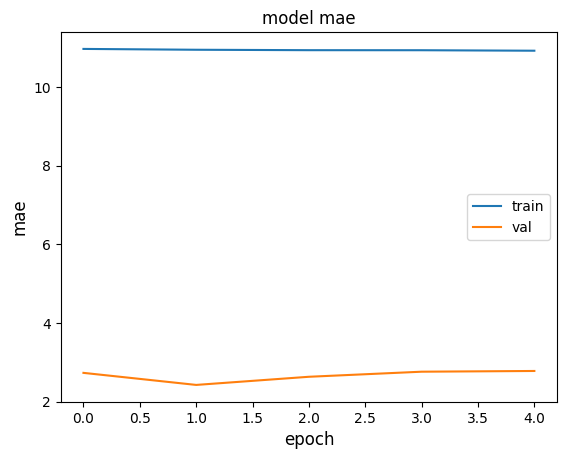

In [35]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [36]:
predictions = model.predict(x_test)

2874/2874 [==============================] - 15s 5ms/step


In [37]:
predictions.shape

(91944, 2, 2)

In [38]:
x_test.shape

(91944, 8, 8)

In [39]:
x_test_exp = x_test[:1, :, :]

In [40]:
x_test_exp.shape

(1, 8, 8)

Visualize some few predictions


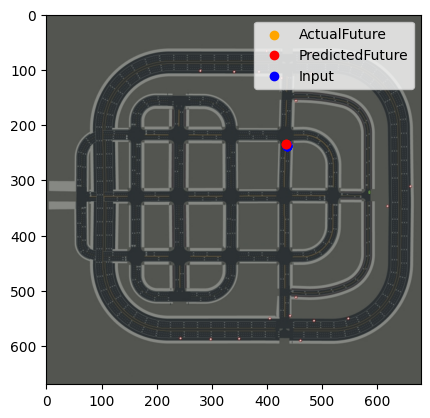

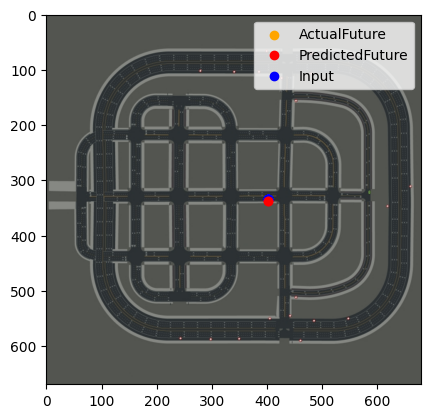

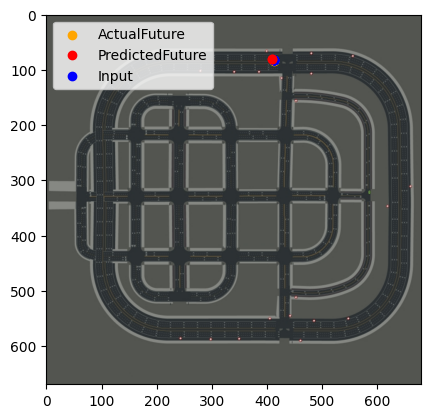

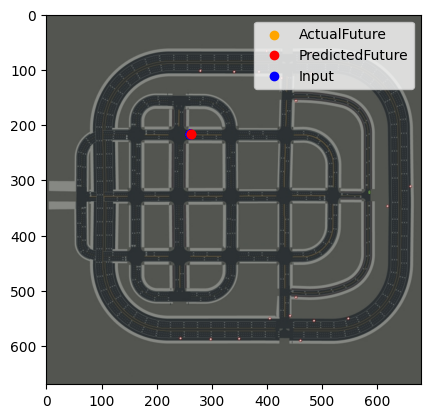

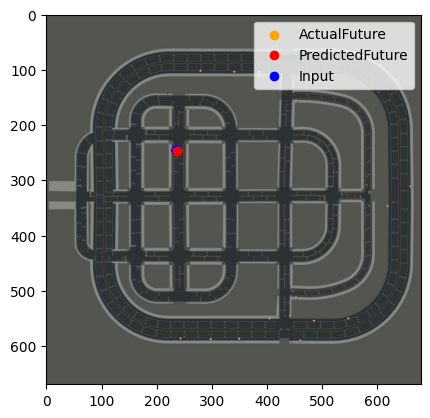

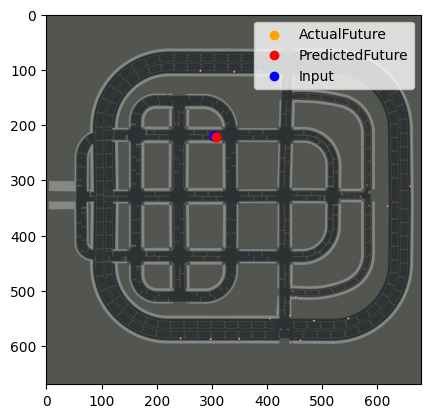

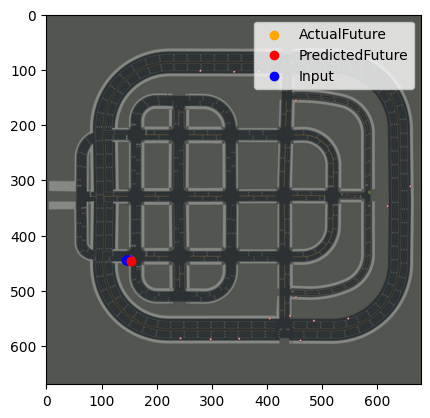

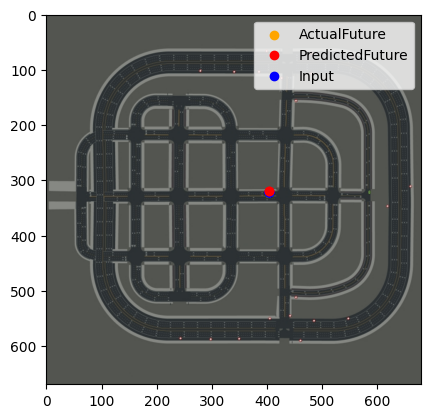

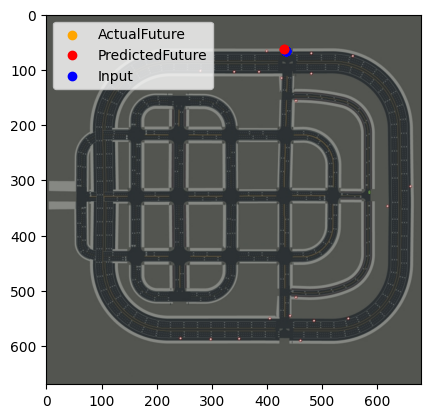

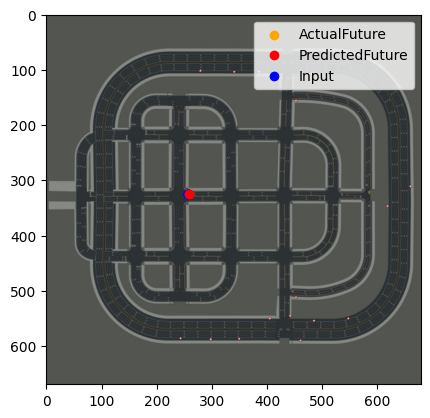

In [41]:
import random
from configs.utils_2 import plot_pred, plot_pred2


print("Visualize some few predictions")

# After finding the best prediction, visualize it
if x_test is not None and y_test is not None and predictions is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(x_test[:, :, :2]))
        plot_pred2(x_test[:, :, :2][index], y_test[index], predictions[index])

## Explainer

### Shap - Adaptive

In [54]:
from explainers.explainer import BlackBoxWrapper


In [59]:
# Define the Shapley value computation functions

def get_sub_set(Tn):
    mylist = list(range(Tn))
    sub_sets = [[]]
    for x in mylist:
        sub_sets.extend([item + [x] for item in sub_sets])
    return sub_sets 

def supertime(interp_x):
    dfx = []
    for i in range(interp_x.shape[1]):  # Iterate over the second axis (time steps)
        dfx.append(interp_x[:, i, :])  # Select all samples at the current time step
    return dfx

def ValFunction(model, interp_x, Tn):
    dfx = supertime(interp_x)
    # Generate subsets of indexes
    subset = get_sub_set(Tn)   
    
    # Generate the baseline
    y_results = model.predict(interp_x)
    baseline = np.mean(y_results, axis=0)
    
    val_results = []
    
    for i in range(1, len(subset)):
        x_i = dfx[subset[i][0]]
        
        if len(subset[i]) == 1:
            print(x_i)
            myBlackbox = BlackBoxWrapper(model) ## Ajout
            #prediction = model.predict(x_i)
            prediction = myBlackbox.predict(x_i)
            print(prediction)
            results = (np.mean(prediction, axis=0)) - baseline
            val_results.append(results)
            
        else:
            for n in range(1, len(subset[i])):
                x_i = np.concatenate([x_i, dfx[subset[i][n]]], axis=0)
            
            #prediction = model.predict(x_i)
            prediction = myBlackbox.predict(x_i)
            results = (np.mean(prediction, axis=0)) - baseline
            val_results.append(results)
            
    val_results.insert(0, np.zeros(baseline.shape))
            
    return subset, val_results

def index(Si, subset):
    for i in range(len(subset)):
        if Si == subset[i]:
            return i
    return -1

def ShapleyValues(model, interp_x, Tn):
    subset, val_results = ValFunction(model, interp_x, Tn)
    shapley_values = []
    for i in range(Tn):
        shapley = []
        for n in range(len(subset)):
            if i not in subset[n]:
                Si = subset[n]+[i]
                Si.sort()
                Si_num = index(Si, subset)
                S_num = len(subset[n])
                N = Tn
                weight = (math.factorial(S_num) * math.factorial((N-S_num-1))) / math.factorial(N)
                val = val_results[Si_num] - val_results[n]
                shapley_i = weight * val
                shapley.append(shapley_i)
        shapley_values.append(np.sum(shapley, axis=0))
    return shapley_values

In [52]:
x_test_exp[0]

array([[ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  2.60932360e-06,  2.00000000e+00,
        -1.68420540e-08,  1.00000000e+00],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  1.71663107e-07,  2.00000000e+00,
         1.04528449e-01,  9.94521897e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  8.92640017e-07,  2.00000000e+00,
         2.07911680e-01,  9.78147603e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  1.64795057e-06,  2.00000000e+00,
         3.09016987e-01,  9.51056519e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  4.26028053e-06,  2.00000000e+00,
         4.06736638e-01,  9.13545460e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  0.00000000e+00,  2.00000000e+00,
         4.99999985e-01,  8.66025412e-01],
       [ 3.22074852e+01,  6.970243

In [43]:
time_steps = 8

In [62]:
shapley_values = ShapleyValues(model, x_test_exp, time_steps)

1/1 [==============================] - 0s 13ms/step
[[ 3.22074852e+01  6.97024384e+01 -1.13048935e-02 -1.18837438e-01
   2.60932360e-06  2.00000000e+00 -1.68420540e-08  1.00000000e+00]]
1/1 [==============================] - 0s 21ms/step
[[[ 7.2051754 12.051173 ]
  [ 7.196825  12.108567 ]]]
[[ 3.22074852e+01  6.97024384e+01 -1.13048935e-02 -1.18837438e-01
   1.71663107e-07  2.00000000e+00  1.04528449e-01  9.94521897e-01]]
1/1 [==============================] - 0s 14ms/step
[[[ 7.211258 12.067981]
  [ 7.202902 12.125385]]]
1/1 [==============================] - 0s 13ms/step
[[ 3.22074852e+01  6.97024384e+01 -1.13048935e-02 -1.18837438e-01
   8.92640017e-07  2.00000000e+00  2.07911680e-01  9.78147603e-01]]
1/1 [==============================] - 0s 13ms/step
[[[ 7.2166023 12.082748 ]
  [ 7.208235  12.1401615]]]
1/1 [==============================] - 0s 13ms/step
[[ 3.22074852e+01  6.97024384e+01 -1.13048935e-02 -1.18837438e-01
   1.64795057e-06  2.00000000e+00  3.09016987e-01  9.51056519e

In [66]:
shapley_values

[array([[-3.04926401, -7.43586831],
        [-3.05065606, -7.43624098]]),
 array([[-3.04701101, -7.42964281],
        [-3.04840517, -7.43001112]]),
 array([[-3.04503139, -7.42417249],
        [-3.04642955, -7.42453838]]),
 array([[-3.04334835, -7.41951973],
        [-3.0447488 , -7.41988189]]),
 array([[-3.04197642, -7.41573593],
        [-3.04337975, -7.41609444]]),
 array([[-3.04093593, -7.41286187],
        [-3.04233961, -7.41321781]]),
 array([[-3.04023568, -7.41092663],
        [-3.04164035, -7.41128198]]),
 array([[-3.03988397, -7.40995295],
        [-3.04128934, -7.41030948]])]

In [68]:
shapley_values[0]

array([[-3.04926401, -7.43586831],
       [-3.05065606, -7.43624098]])